In [12]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers,datasets,utils,models
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation, Flatten,Input
from tensorflow.compat.v1.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.compat.v1.keras.applications.resnet50 import ResNet50
import numpy as np
from tensorflow.compat.v1.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

由于gpu内存内存不足以存下所有的图片，启动灵活分配。

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

### 设定参数

设定一下batch大小，类别数，训练轮数，还有就是启用数据增强。

In [3]:
batch_size = 16 
num_classes = 10
epochs = 5
data_augmentation = True

### 数据加载以及预处理

数据集实现下载。

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
train_index = np.random.permutation(x_train.shape[0])
test_index = np.random.permutation(x_test.shape[0])

In [7]:
little_x_train = (x_train[train_index,:,:,:])[:5000, :,:,:]
little_y_train = (y_train[train_index,:])[:5000,:]
little_x_test = (x_test[test_index,:,:,:])[:1000,:,:,:]
little_y_test = (y_test[test_index,:])[:1000,:]
print(little_x_train.shape)
print(little_y_train.shape)
print(little_x_test.shape)
print(little_y_test.shape)
x_train = little_x_train
y_train = little_y_train
x_test = little_x_test
y_test = little_y_test

(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)


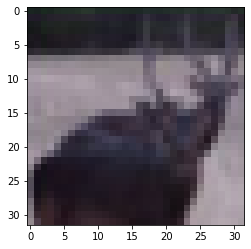

In [8]:
plt.imshow(x_train[0,:,:,:])

对数据归一化、独热编码化。

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### 下载预训练的resnet-50模型

In [16]:
basemodel = ResNet50(include_top = False,pooling = 'max',weights = 'imagenet')
Inp = Input((32, 32, 3))
#x = GlobalAveragePooling2D()(basemodel(Inp))
x = Dense(1024,activation = 'relu')(basemodel(Inp))
predictions = Dense(num_classes,activation = 'softmax')(x)
x.trainable = True
resnet50_fine_tune = Model(inputs=Inp, outputs=predictions)

for each in basemodel.layers:
    each.trainable = False

In [11]:
resnet50_fine_tune = keras.models.Sequential()
resnet50_fine_tune.add(ResNet50(include_top = False,
                                pooling = 'max',
                                weights = 'imagenet'))
resnet50_fine_tune.add(Dense(num_classes,activation = 'softmax'))
resnet50_fine_tune.layers[0].trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
opt = keras.optimizers.Adam(lr=0.001)
resnet50_fine_tune.compile(loss="categorical_crossentropy",optimizer=opt,metrics = ["accuracy"])
resnet50_fine_tune.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________


### 开启tensorboard

In [12]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='.\\Graph1', histogram_freq=0, write_graph=True, write_images=True)

### 开启训练

In [20]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[tbCallBack])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    '''
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    '''
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    resnet50_fine_tune.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/5
313/313 [==============================] - 41s 132ms/step - loss: 2.1554 - accuracy: 0.3014 - val_loss: 3.4045 - val_accuracy: 0.0870
Epoch 2/5
313/313 [==============================] - 42s 135ms/step - loss: 1.7923 - accuracy: 0.3698 - val_loss: 3.4185 - val_accuracy: 0.1220
Epoch 3/5
313/313 [==============================] - 41s 130ms/step - loss: 1.7485 - accuracy: 0.3840 - val_loss: 4.1530 - val_accuracy: 0.0870
Epoch 4/5
313/313 [==============================] - 42s 133ms/step - loss: 1.7270 - accuracy: 0.3962 - val_loss: 3.0574 - val_accuracy: 0.0870
Epoch 5/5
313/313 [==============================] - 42s 135ms/step - loss: 1.6928 - accuracy: 0.4054 - val_loss: 4.1035 - val_accuracy: 0.0980


In [14]:
def conv_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [17]:
vggmodel = conv_model()

# initiate RMSprop optimizer
opt = keras.optimizers.Adam(lr=0.0001)

# Let's train the model using RMSprop
vggmodel.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
vggCallBack = keras.callbacks.TensorBoard(log_dir='.\\Graph2', histogram_freq=0, write_graph=True, write_images=True)

In [20]:
vggmodel.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test), callbacks=[vggCallBack])

Epoch 1/30
312/312 [==============================] - 17s 55ms/step - loss: 2.2863 - accuracy: 0.1069 - val_loss: 2.2197 - val_accuracy: 0.1900
Epoch 2/30
312/312 [==============================] - 16s 51ms/step - loss: 2.1507 - accuracy: 0.1756 - val_loss: 2.0239 - val_accuracy: 0.2180
Epoch 3/30
312/312 [==============================] - 16s 52ms/step - loss: 2.0333 - accuracy: 0.2113 - val_loss: 1.9077 - val_accuracy: 0.2410
Epoch 4/30
312/312 [==============================] - 16s 51ms/step - loss: 1.9661 - accuracy: 0.2372 - val_loss: 1.9232 - val_accuracy: 0.2590
Epoch 5/30
312/312 [==============================] - 16s 51ms/step - loss: 1.9376 - accuracy: 0.2490 - val_loss: 1.8517 - val_accuracy: 0.3210
Epoch 6/30
312/312 [==============================] - 16s 51ms/step - loss: 1.9071 - accuracy: 0.2695 - val_loss: 1.7925 - val_accuracy: 0.3250
Epoch 7/30
312/312 [==============================] - 16s 52ms/step - loss: 1.8767 - accuracy: 0.2867 - val_loss: 1.8238 - val_accuracy:

In [21]:
vggmodel.load_weights('./model/initmethods_weigths.h5')

In [18]:
pre = np.argmax(resnet50_fine_tune.predict(x_train), axis=1)

In [19]:
#print(np.argmax(y_train[:10], axis=1))
print(pre[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
pre[100:110]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64)

In [29]:
y_test.shape

(1000, 10)

In [14]:
sucess = len([each for each in (pre == np.argmax(y_train, axis=1)) if each==True])/len(pre)
print(sucess)

0.0988
